In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import math

import warnings
warnings.filterwarnings('ignore')

# Read Data and Initial Inspection

Phase 1: original data

In [2]:
dataPath = '../../data/'
dataset = pd.read_csv(dataPath+'Clean_RawData.csv')
dataset.head()

,Archive No,D (m),l,m (kg),v (m/s),E (kPa),cu (kPa),E/cu,G/cu,Total penetration/ D,Time of travel (s),Initial Kinetic Energy = mv2/2 (kgm2/s2),(cupD3/4) (kgm2/s2),(mv2/2)/ (cupD3/4)
0,1,0.04,0.0,0.1,5,100,1,100,33.333333,4.0678,0.06678,1.25,0.050265,24.867960
1,3,0.04,0.0,0.2,5,100,1,100,33.333333,7.9759,0.13092,2.50,0.050265,49.735920
2,13,0.04,0.0,0.1,10,500,5,100,33.333333,3.2486,0.02578,5.00,0.251327,19.894368
3,16,0.04,0.0,0.2,10,500,5,100,33.333333,5.7715,0.04606,10.00,0.251327,39.788736
4,19,0.04,0.0,0.5,5,500,5,100,33.333333,4.2121,0.06164,6.25,0.251327,24.867960


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 14 columns):
Archive No                                  223 non-null int64
D (m)                                       223 non-null float64
l                                           223 non-null float64
m (kg)                                      223 non-null float64
v (m/s)                                     223 non-null int64
E (kPa)                                     223 non-null int64
cu (kPa)                                    223 non-null int64
E/cu                                        223 non-null int64
G/cu                                        223 non-null float64
Total penetration/ D                        223 non-null float64
Time of travel (s)                          223 non-null float64
Initial Kinetic Energy = mv2/2 (kgm2/s2)    223 non-null float64
(cupD3/4) (kgm2/s2)                         223 non-null float64
(mv2/2)/ (cupD3/4)                          223 non-null flo

Nothing looks weird so far; data columns are all numeric.

The names of the columns, however, are not gonna be convenient for coding, so I am simplifying them for now and we can later on revert them back to original names if desired.

In [4]:
def simplifyNames(df, names):
    df.rename(columns = names, inplace = True)

def reventBackNames(df, names):
    invNames = {v: k for k, v in names.items()}
    df.rename(columns = invNames, inplace = True)

In [5]:
columnNames = {'Archive No': 'id','D (m)': 'd', 'l': 'lambda', 'm (kg)': 'm', 'v (m/s)': 'v', 'E (kPa)': 'e', 'cu (kPa)': 'cu', 
               'E/cu': 'e/cu', 'G/cu': 'g/cu', 'Total penetration/ D': 'tp/d', 'Time of travel (s) ': 'tt',
               'Initial Kinetic Energy = mv2/2 (kgm2/s2)': 'ike', '(cupD3/4) (kgm2/s2)': 'cup', '(mv2/2)/ (cupD3/4)': 'ke/cup'}

simplifyNames(dataset, columnNames)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 14 columns):
id        223 non-null int64
d         223 non-null float64
lambda    223 non-null float64
m         223 non-null float64
v         223 non-null int64
e         223 non-null int64
cu        223 non-null int64
e/cu      223 non-null int64
g/cu      223 non-null float64
tp/d      223 non-null float64
tt        223 non-null float64
ike       223 non-null float64
cup       223 non-null float64
ke/cup    223 non-null float64
dtypes: float64(9), int64(5)
memory usage: 24.5 KB


### Missing Values

In [6]:
dataset.isnull().sum()

id        0
d         0
lambda    0
m         0
v         0
e         0
cu        0
e/cu      0
g/cu      0
tp/d      0
tt        0
ike       0
cup       0
ke/cup    0
dtype: int64

PERFECT; there is no missing values... Well we did expect it as these are data generated from simulation, so indeed there won't be any missing values... daahhh :)

# EDA

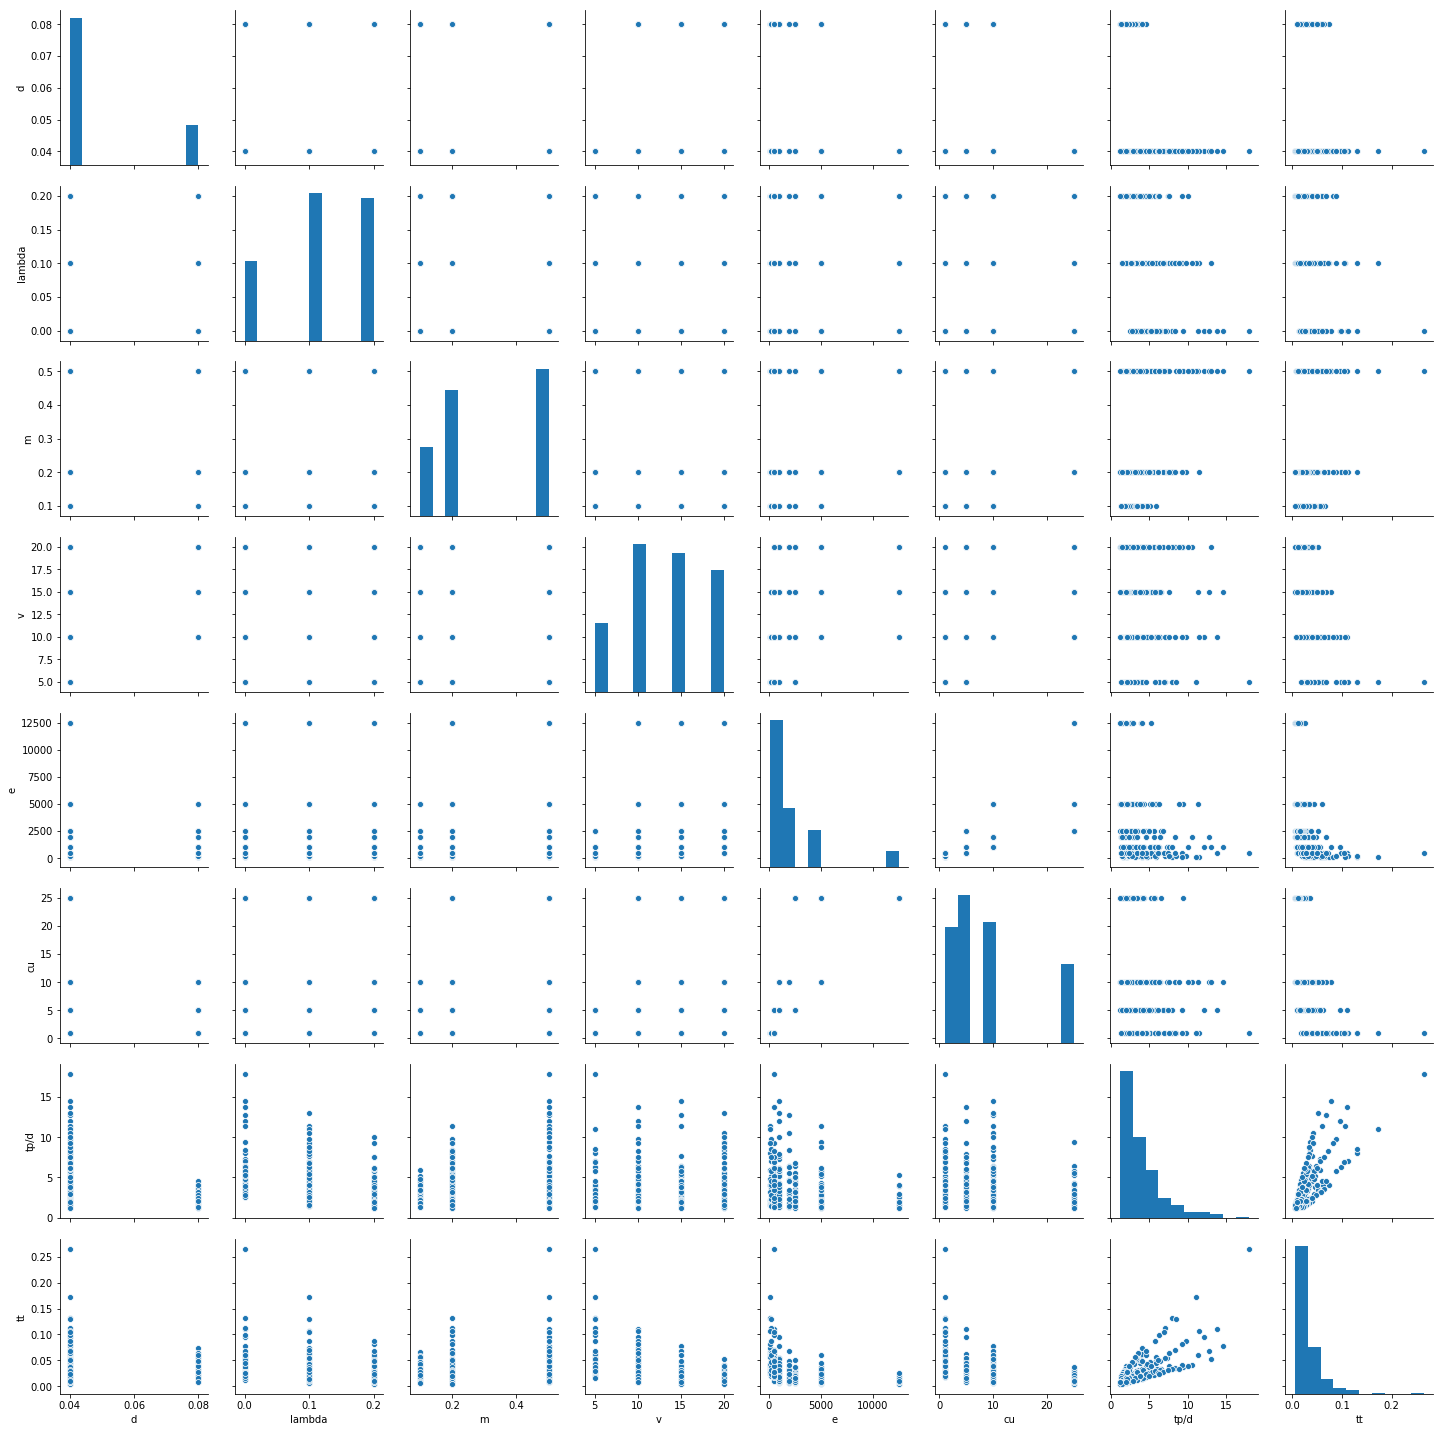

In [7]:
cols = ['d', 'lambda', 'm', 'v', 'e', 'cu', 'tp/d', 'tt']
sns.pairplot(dataset[cols], height = 2.5)
plt.show();

looks like there are some extreme e, cu, time and penetration parameters. But for now we will keep them in as I believe they will help with the interpolation rather than extrapolation! 

In this regards, I am also curious to see how many various instances we have per target variable variation?... 

In [8]:
targetCols = ['e', 'cu', 'lambda']
for col in targetCols:
    for val in dataset[col].unique():
        filteredData = dataset[dataset[col] == val]
        print("for value", val, "of variable", col, "there are", filteredData.shape[0], "instances in the dataset.")

for value 100 of variable e there are 14 instances in the dataset.
for value 500 of variable e there are 46 instances in the dataset.
for value 1000 of variable e there are 46 instances in the dataset.
for value 2500 of variable e there are 32 instances in the dataset.
for value 200 of variable e there are 20 instances in the dataset.
for value 2000 of variable e there are 19 instances in the dataset.
for value 5000 of variable e there are 32 instances in the dataset.
for value 12500 of variable e there are 14 instances in the dataset.
for value 1 of variable cu there are 56 instances in the dataset.
for value 5 of variable cu there are 71 instances in the dataset.
for value 10 of variable cu there are 58 instances in the dataset.
for value 25 of variable cu there are 38 instances in the dataset.
for value 0.0 of variable lambda there are 48 instances in the dataset.
for value 0.1 of variable lambda there are 89 instances in the dataset.
for value 0.2 of variable lambda there are 86 in

Interesting! Above analysis shows that for some values of target variable, particularly in case of Young's Modulus, there are values with number of instances as low as 14! This should still be alright, but we need to be careful when we form our Train/Test splits of the dataset.

### Correlations

,d,m,v,tp/d,tt,lambda,e,cu
d,1.000000,0.171369,0.284365,-0.312248,-0.078955,0.170552,-0.209341,-0.300248
m,0.171369,1.000000,-0.000480,0.220268,0.189846,-0.008402,0.188830,0.265778
v,0.284365,-0.000480,1.000000,-0.005942,-0.435421,0.093523,0.276841,0.364458
tp/d,-0.312248,0.220268,-0.005942,1.000000,0.740233,-0.381876,-0.174410,-0.139742
tt,-0.078955,0.189846,-0.435421,0.740233,1.000000,-0.318218,-0.335149,-0.406026
lambda,0.170552,-0.008402,0.093523,-0.381876,-0.318218,1.000000,-0.076738,-0.096936
e,-0.209341,0.188830,0.276841,-0.174410,-0.335149,-0.076738,1.000000,0.747132
cu,-0.300248,0.265778,0.364458,-0.139742,-0.406026,-0.096936,0.747132,1.000000


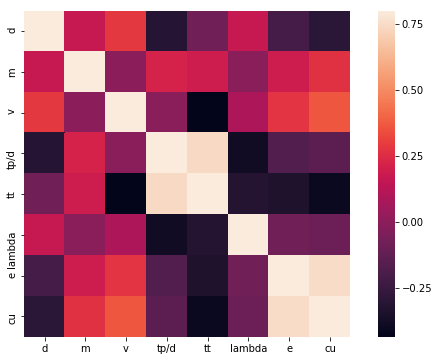

In [9]:
#correlation matrix
corrmat = dataset[['d', 'm', 'v', 'tp/d', 'tt', 'lambda', 'e', 'cu']].corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corrmat, vmax=0.8, square=True)
corrmat

# Feature Engineering

This is to investigate if we can benefit from other more complext features (built from the original feature set). Our metric for value of new features would be impact on correlations;

### 'e/cu' and 'g/cu' instead of 'e' and 'cu'

Note that 'e' and 'cu' can be calculated if 'e/cu' and 'g/cu' are known.

,d,m,v,tp/d,tt,e/cu,g/cu
d,1.000000,0.171369,0.284365,-0.312248,-0.078955,0.062980,0.062980
m,0.171369,1.000000,-0.000480,0.220268,0.189846,-0.001963,-0.001963
v,0.284365,-0.000480,1.000000,-0.005942,-0.435421,0.016201,0.016201
tp/d,-0.312248,0.220268,-0.005942,1.000000,0.740233,-0.150852,-0.150852
tt,-0.078955,0.189846,-0.435421,0.740233,1.000000,-0.085432,-0.085432
e/cu,0.062980,-0.001963,0.016201,-0.150852,-0.085432,1.000000,1.000000
g/cu,0.062980,-0.001963,0.016201,-0.150852,-0.085432,1.000000,1.000000


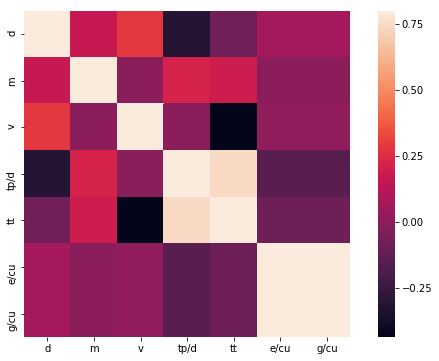

In [10]:
#correlation matrix: replace e and cu, with e/cu and g/cu
corrmat = dataset[['d', 'm', 'v', 'tp/d', 'tt', 'e/cu', 'g/cu']].corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corrmat, vmax=0.8, square=True)
corrmat

The correlations have generally dropped! Let's use the original 'e' and 'cu' as the target variables.

### 'v2' and 'ike'

,d,m,v,v2,ike,tp/d,tt,lambda,e,cu
d,1.000000,0.171369,0.284365,0.280375,0.352739,-0.312248,-0.078955,0.170552,-0.209341,-0.300248
m,0.171369,1.000000,-0.000480,0.005482,0.576393,0.220268,0.189846,-0.008402,0.188830,0.265778
v,0.284365,-0.000480,1.000000,0.983861,0.707335,-0.005942,-0.435421,0.093523,0.276841,0.364458
v2,0.280375,0.005482,0.983861,1.000000,0.723375,0.006402,-0.390603,0.090246,0.252990,0.327705
ike,0.352739,0.576393,0.707335,0.723375,1.000000,0.121520,-0.197108,0.066279,0.273428,0.371638
tp/d,-0.312248,0.220268,-0.005942,0.006402,0.121520,1.000000,0.740233,-0.381876,-0.174410,-0.139742
tt,-0.078955,0.189846,-0.435421,-0.390603,-0.197108,0.740233,1.000000,-0.318218,-0.335149,-0.406026
lambda,0.170552,-0.008402,0.093523,0.090246,0.066279,-0.381876,-0.318218,1.000000,-0.076738,-0.096936
e,-0.209341,0.188830,0.276841,0.252990,0.273428,-0.174410,-0.335149,-0.076738,1.000000,0.747132
cu,-0.300248,0.265778,0.364458,0.327705,0.371638,-0.139742,-0.406026,-0.096936,0.747132,1.000000


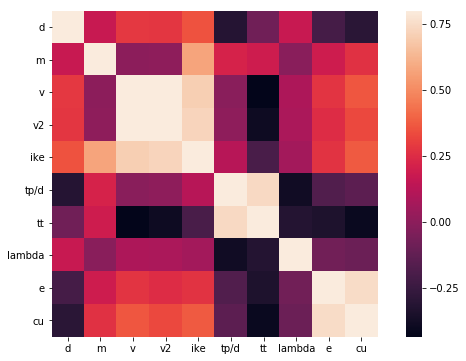

In [11]:
dataset['v2'] = np.square(dataset['v'])
#correlation matrix: replace e and cu, with e/cu and g/cu
corrmat = dataset[['d', 'm', 'v', 'v2', 'ike', 'tp/d', 'tt', 'lambda', 'e', 'cu']].corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corrmat, vmax=0.8, square=True)
corrmat

Doesn't look like 'V2' is actually increasing magnitude of correlation! but this might be too soon to say. What is clear is that to avoid multicollinearity, we must not use all 'm', 'v', 'v2' and 'ike' altogether, but rather independent subsets of them. We will check the performance later in modelling section. 

### 'tp' instead of 'tp/d'

'tp/d' created multicollinearity in the predictor set, which results in poor performance of some classes of ML models. Hence we'd rather keep 'tp' and 'd' separately as part of the features.

,d,m,v,tp,tt
d,1.000000,0.171369,0.284365,0.012781,-0.078955
m,0.171369,1.000000,-0.000480,0.314968,0.189846
v,0.284365,-0.000480,1.000000,0.079235,-0.435421
tp,0.012781,0.314968,0.079235,1.000000,0.757213
tt,-0.078955,0.189846,-0.435421,0.757213,1.000000


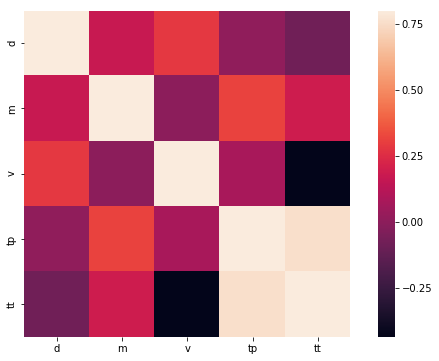

In [12]:
dataset['tp'] = dataset.apply(lambda x: x['tp/d']*x['d'], axis=1)
corrmat = dataset[['d', 'm', 'v', 'tp', 'tt']].corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corrmat, vmax=0.8, square=True)
corrmat

Great! We can obviouly see that the multicollinearity between 'd' and 'tp/d' is now gone by using 'tp' instead of 'tp/d. 

# Modelling

## Phase 1: Regression on Limited Data

### Prepare Train and Test Data

### IMPORTANT NOTE:
I create train data by random picking from the original dataset but in a certain loop aiming at getting a more balanced train dataset in terms of various ranges of target values. Because of randomness, train and test data need to be created once and written out; any further usage must read from csv; The loop can be controled using the flag "fisrtTime"

In [43]:
firstTime = False
if firstTime:
    targetCols = ['e', 'cu', 'lambda']
    trainDf = pd.DataFrame()
    for col in targetCols:
        for val in dataset[col].unique():
            filteredData = dataset[dataset[col] == val]
            trainDf = trainDf.append(filteredData.loc[np.random.choice(filteredData.index, 11), :])

    trainDf.to_csv("../../data/train_data.csv", index=False)
    testDf = pd.concat([dataset, trainDf]).drop_duplicates(keep=False)
    testDf.to_csv("../../data/test_data.csv", index=False)
else:
    trainDf = pd.read_csv("../../data/train_data.csv")
    testDf = pd.read_csv("../../data/test_data.csv")

In [44]:
trainDf.head()

,id,d,lambda,m,v,e,cu,e/cu,g/cu,tp/d,tt,ike,cup,ke/cup,v2,tp
0,1,0.04,0.0,0.1,5,100,1,100,33.333333,4.0678,0.06678,1.25,0.050265,24.867960,25,0.162712
1,224,0.04,0.2,0.1,10,100,1,100,33.333333,4.7695,0.04346,5.00,0.050265,99.471839,100,0.190780
2,230,0.08,0.2,0.2,10,100,1,100,33.333333,1.5544,0.02720,10.00,0.402124,24.867960,100,0.124352
3,122,0.08,0.1,0.5,10,100,1,100,33.333333,4.0028,0.07452,25.00,0.402124,62.169900,100,0.320224
4,116,0.04,0.1,0.5,5,100,1,100,33.333333,11.0397,0.17186,6.25,0.050265,124.339799,25,0.441588


### Normality of target variables

This is for the current analysis where we want to use Regression models for the task of prediction. We have to remember that this type of problem could also be modelled as a Classification problem, where instead of predicting continuous values of the target variable, we model the target as classes (e.g. example classes (bins) for cu: 0 to 5, 5 to 10, 10 to 20, 20 to 30 etc). I do recommend that we visit this as well, perhaps after Regression modelling.

This is aming at improving the prediction power of models further down the road. Normality of the arget variable is one of the Assumptions of Linear Regressi

Skew is: 1.73627534334192


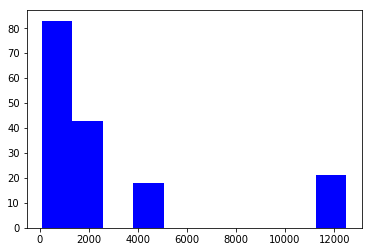

Skew is: -0.17387084565429226


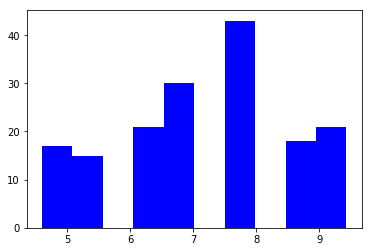

In [45]:
#Check skewness of the original data
print ("Skew is:", trainDf['e'].skew())
plt.hist(trainDf['e'], color='blue')
plt.show()

#Does log transformation make things better?
target = np.log(trainDf.loc[trainDf['e']>0,'e'])
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

#Yes, log is less skewed, so lets transform the original values
trainDf['e'] = np.log(trainDf['e'])

Skew is: 0.7818200228168004


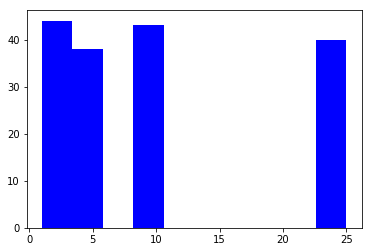

Skew is: -0.3694991992323276


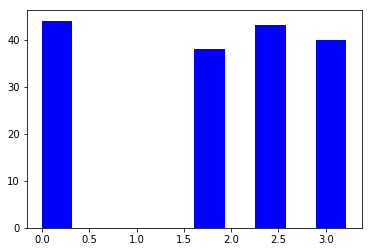

In [46]:
#Check skewness of the original data
print ("Skew is:", trainDf['cu'].skew())
plt.hist(trainDf['cu'], color='blue')
plt.show()

#Does log transformation make things better?
target = np.log(trainDf.loc[trainDf['cu']>0,'cu'])
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

#Yes, log is less skewed, so lets transform the original values
trainDf['cu'] = np.log(trainDf['cu'])

'e' and 'cu' do benefit from log transformation in terms of getting them closer to normality. However, 'lambda' has only 3 values, one of which is zero. Hence, it would not benefit from log transfromation.

Skew is: 0.5031080166531708


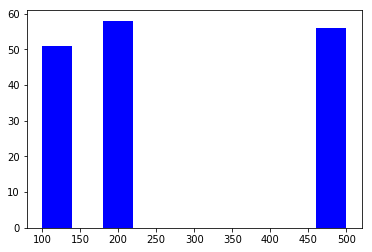

Skew is: 0.12489383391756997


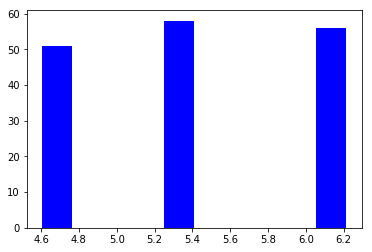

In [47]:
#Check skewness of the original data
print ("Skew is:", trainDf['e/cu'].skew())
plt.hist(trainDf['e/cu'], color='blue')
plt.show()

#Does log transformation make things better?
target = np.log(trainDf.loc[trainDf['e/cu']>0,'e/cu'])
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

#Yes, log is less skewed, so lets transform the original values
#trainDf['e/cu'] = np.log(trainDf['e/cu'])

In [109]:
def prepareTrainAndTest(data, predictors):
    XDict = {}
    yDict = {}
    for key in predictors.keys():
        XDict[key] = data[predictors[key]]
        yDict[key] = data[key]
    
    return (XDict, yDict)
    
predictors = {'cu': ['m', 'v', 'd', 'tt', 'tp', 'ike'], 
              'e': ['m', 'v', 'd', 'tt', 'tp', 'ike'], 
              'lambda': ['m', 'v', 'd', 'tt', 'tp', 'ike']}

(X_trainDict, y_trainDict) = prepareTrainAndTest(trainDf, predictors)
(X_testDict, y_testDict) = prepareTrainAndTest(testDf, predictors)

### Scaling

In [110]:
from sklearn.preprocessing import StandardScaler
def standardSaleData(X_train, X_test, y_train):
    sc_X = {}
    sc_y = {}
    for key in X_train.keys():
        sc_X[key] = StandardScaler()
        X_train[key] = sc_X[key].fit_transform(X_train[key].values)
        X_test[key] = sc_X[key].transform(X_test[key].values)
    
        sc_y[key] = StandardScaler()
        y_train[key] = sc_y[key].fit_transform(y_train[key].values.reshape(-1, 1))
    
    return sc_y

sc_yDict = standardSaleData(X_trainDict, X_testDict, y_trainDict)

In [111]:
#****************** Ensemble Models *******************************************
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, ARDRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV, cross_val_score

#Modeling step Test differents algorithms 
random_state = 0
regressors = []
regNames = []

regressors.append(LinearRegression())
#regressors.append(Lasso(random_state=random_state))
regressors.append(Ridge(random_state=random_state))
#regressors.append(ElasticNet(random_state=random_state))
regressors.append(BayesianRidge())
regressors.append(ARDRegression())

regressors.append(MLPRegressor(random_state=random_state))
regressors.append(SVR(kernel='linear'))
#regressors.append(SVR(kernel='poly', degree=2))
#regressors.append(SVR(kernel='poly'))
regressors.append(SVR(kernel='rbf'))

#regressors.append(AdaBoostRegressor(random_state=random_state))
regressors.append(RandomForestRegressor(random_state=random_state))
regressors.append(BaggingRegressor(random_state=random_state))

regressors.append(XGBRegressor(random_state=random_state))

regNames = ["LR", "L2", "BR", "ARD", "MLP", "SVR-LR", "SVR-Rbf", "RF", "Bag", "XGB"]
scorers = ["r2"]

#print(regressors)

In [112]:
def transformWithKernelPca(X):
    transformer = KernelPCA(n_components=5, kernel='poly', degree = 2, random_state = 0, gamma = 0.09)
    return transformer.fit_transform(X)
    
def plotCVResults(data, stdData, title, figNum):
    plt.figure(figNum)
    g = sns.barplot("CrossValMeans", "Algorithm", data = data, palette="Set3", orient = "h", **{'xerr':stdData})
    g.set_title(title)
    
def obtainCVRegressionResults(X, y, scorer, title, regNames, regressors, figNum = 0, withPlot = True, printFlag = True):
    cvResults = []
    names = []
    for index, regressor in enumerate(regressors):
        try:
            cvResults.append(cross_val_score(regressor, X, y = y, scoring = scorer, cv = 10, n_jobs = 1))
            names.append(regNames[index])
        except:
            print("Regressor ", regNames[index], "generated an error!")

    cvMeans = []
    cvStd = []
    for cvResult in cvResults:
        cvMeans.append(cvResult.mean())
        cvStd.append(cvResult.std())

    cvRes = pd.DataFrame({"CrossValMeans":cvMeans, "CrossValerrors":cvStd, "Algorithm":names})
    
    if printFlag:
        print(title)
        print(cvRes,"\n")
    
    if withPlot:
        plotCVResults(cvRes, cvStd, title, figNum)
    
    return cvRes    
    
def runAllModelsWithAllMetrics(X, y, targetVar, scorers, regNames, regressors, figNumRoot = 0, withKernelPca = False, withPlot = True):
    if withKernelPca:
        X = transformWithKernelPca(X)
    for index, metric in enumerate(scorers):
        title = "Modelling '"+str(targetVar)+"' - Metric: "+str(metric)
        obtainCVRegressionResults(X, y, metric, title, regNames, regressors, figNum=figNumRoot+index, withPlot = withPlot)
        
def runAllModelsForAllTargetVariables(X_Dict, y_Dict, scorers, regNames, regressors, withKernelPca = False, withPlot = True):
    for index, targetVar in enumerate(X_Dict.keys()):       
        runAllModelsWithAllMetrics(X_Dict[targetVar], y_Dict[targetVar], targetVar, scorers, regNames, regressors, figNumRoot = index, withKernelPca = withKernelPca, withPlot = withPlot)

In [113]:
runAllModelsForAllTargetVariables(X_trainDict, y_trainDict, scorers, regNames, regressors, withKernelPca = True, withPlot = False)

Modelling 'cu' - Metric: r2
  Algorithm  CrossValMeans  CrossValerrors
0        LR       0.288115        0.621979
1        L2       0.300198        0.631473
2        BR       0.292517        0.623572
3       ARD       0.318690        0.604595
4       MLP       0.478318        0.503059
5    SVR-LR       0.294882        0.618943
6   SVR-Rbf       0.430098        0.468482
7        RF       0.697250        0.355069
8       Bag       0.706962        0.334601
9       XGB       0.743513        0.268808 

Modelling 'e' - Metric: r2
  Algorithm  CrossValMeans  CrossValerrors
0        LR      -0.424695        1.333093
1        L2      -0.408364        1.389989
2        BR      -0.416891        1.354288
3       ARD      -0.414431        1.346780
4       MLP      -0.240942        1.201021
5    SVR-LR      -0.506383        1.561215
6   SVR-Rbf      -0.446592        1.643918
7        RF      -0.537943        1.959493
8       Bag      -0.492042        1.862706
9       XGB      -0.312154        1.5498

## Feature Selection

With XGB as the selected regressor, we'd like to have a view on how various feature sets can affect the accuracy of predictions. It is just experimental!

In [22]:
from itertools import combinations
def getSubLists(myList, exceptions, mustHave):
    x = len(myList)
    subs = []
    for i in range(1 << x):
        sub = [myList[j] for j in range(x) if (i & (1 << j))]
        #print(sub)
        if not(sub in exceptions) and (len(sub) > 1) and (set(mustHave).issubset(set(sub))):
            subs.append(sub)
    return subs

potentialFeatures_cu = getSubLists(['m', 'v', 'v2', 'd', 'tt', 'tp', 'tp/d', 'ike'], [[]], [])
potentialFeatures_other = getSubLists(['m', 'v', 'v2', 'd', 'tt', 'tp', 'tp/d', 'ike', 'cup', 'ke/cup'], [[]], [])

potentialPredictors = []
for featureSet_cu in potentialFeatures_cu:
    for featureSet_other in potentialFeatures_other:
        potentialPredictors.append({'cu': featureSet_cu, 'e': featureSet_other, 'lambda': featureSet_other})

In [ ]:
bestRes = {'cu': -1000, 'e': -1000, 'lambda': -1000} 
bestPredictorIndicesAndRegressor = {'cu': [0, ""], 'e': [0, ""], 'lambda': [0, ""]} 
results = {} 

for regIndex, regressor in enumerate(regressors):
    results[regressor] = {}
    for index, predictors in enumerate(potentialPredictors):
        (X_trainDict, y_trainDict) = prepareTrainAndTest(trainDf, predictors)
        (X_testDict, y_testDict) = prepareTrainAndTest(testDf, predictors)
        sc_yDict = standardSaleData(X_trainDict, X_testDict, y_trainDict)
        results[regressor][index] = {}
        for targetVar in X_trainDict.keys():
            results[regressor][index][targetVar] = obtainCVRegressionResults(X_trainDict[targetVar], y_trainDict[targetVar], 
                                                                  "r2", 
                                                                  "Predictor set of index "+str(index)+" for target "+str(targetVar),  
                                                                  [regNames[regIndex]], [regressor], withPlot = False, printFlag = False)
        if results[regressor][index][targetVar].iloc[0, 1] > bestRes[targetVar]:
            bestRes[targetVar] = results[regressor][index][targetVar].iloc[0, 1]
            bestPredictorIndicesAndRegressor[targetVar] = [index, regIndex]

In [ ]:
print(bestRes)
print(bestPredictorIndicesAndRegressor)

## Prediction

In [ ]:
def reverseTransformPredictions(preds, sc, logFlag):
    res = sc.inverse_transform(preds)
    if logFlag:
        return np.exp(res)
    return res

predictors = {'cu': potentialPredictors[bestPredictorIndicesAndRegressor['cu'][0]]['cu'], 
              'e': potentialPredictors[bestPredictorIndicesAndRegressor['e'][0]]['e'], 
              'lambda': potentialPredictors[bestPredictorIndicesAndRegressor['lambda'][0]]['lambda']}

(X_trainDict, y_trainDict) = prepareTrainAndTest(trainDf, predictors)
(X_testDict, y_testDict) = prepareTrainAndTest(testDf, predictors)
sc_yDict = standardSaleData(X_trainDict, X_testDict, y_trainDict)

testData = testDf.copy(deep=True)
logFlags = {'cu':True, 'e':True, 'lambda':False}
for targetVar in X_trainDict.keys():
    reg = regressors[bestPredictorIndicesAndRegressor[targetVar][1]] #XGBRegressor(random_state=random_state)
    reg.fit(X_trainDict[targetVar], y_trainDict[targetVar])
    yResults = reg.predict(X_testDict[targetVar])
    testData[str(targetVar)+"_pred"] = reverseTransformPredictions(yResults, sc_yDict[targetVar], logFlags[targetVar])
    testData[str(targetVar)+"_method"] = [regNames[bestPredictorIndicesAndRegressor[targetVar][1]] for i in range(0, testData.shape[0])]
    
testData.to_csv("../../data/output/best_model_best_features_predictions.csv", index=False)

In [ ]:
#**********************GRID SEARCH ********************************************
from sklearn.model_selection import GridSearchCV
def evaluateModelPerformance(est, params, X, y):
    grid_search = GridSearchCV(estimator = est,
                               param_grid = params,
                               scoring = "neg_mean_squared_error",
                               cv = 5, n_jobs = 3)
    
    grid_search = grid_search.fit(X, y)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    return best_accuracy, best_parameters
#******************************************************************************    
#****************** XGBoost ***************************************************
tuningDict = {}
# Fitting XGBoost to the Training set
from xgboost import XGBRegressor
regressor = XGBRegressor()
#regressor.fit(X, y)

In [ ]:
#Step All:
parameters = {'n_estimators': [i for i in range(400, 1000, 50)],
             'learning_rate': [0.1],
             'max_depth': [i for i in range(3,8)],
             'min_child_weight': [3, 4, 5, 6, 7, 8],
             'gamma': [i*0.1 for i in range(0, 85, 5)],
             'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_alpha':[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_lambda':[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-All'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
#Step 1:fix learning rate and determine optimum n_estimators:
parameters = {'n_estimators': [i for i in range(400, 1000, 50)],
             'learning_rate': [0.1]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-1'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
#Step 2:Tune max_depth and min_child_weight:
parameters = {'n_estimators': [600],
             'learning_rate': [0.1],
             'max_depth': [i for i in range(3,11)],
             'min_child_weight': [1, 2, 3, 5, 6, 7, 8, 9, 10]}
score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-2'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
#Step 3:Tune gamma:
parameters = {'n_estimators': [600],
             'learning_rate': [0.1],
             'max_depth': [4],
             'min_child_weight': [5],
             'gamma': [i*0.1 for i in range(0, 100, 2)]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-3'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
#Step 4:Tune subsample and colsample_bytree:
parameters = {'n_estimators': [600],
             'learning_rate': [0.1],
             'max_depth': [4],
             'min_child_weight': [5],
             'gamma': [4.0],
             'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-4'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
#Step 5:Tuning Regularization Parameters:
parameters = {'n_estimators': [150],
             'learning_rate': [0.1],
             'max_depth': [3],
             'min_child_weight': [1],
             'gamma': [0.0],
             'subsample': [1.0],
             'colsample_bytree': [1.0],
             'reg_alpha':[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_lambda':[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-5'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
#Step 6: Tuning (decreasing) learning rate and n_estimators again:
parameters = {'n_estimators': [50*i for i in range(1, 20, 1)],
             'learning_rate': [0.01*i for i in range(1, 11, 1)],
             'max_depth': [3],
             'min_child_weight': [1],
             'gamma': [0.0],
             'subsample': [1.0],
             'colsample_bytree': [1.0],
             'reg_alpha':[0.4],
             'reg_lambda':[0.9]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-6'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
# Fitting tuned XGBoost and get the results
classifier = XGBClassifier(n_estimators= 150,
             learning_rate= 0.1,
             max_depth= 3,
             min_child_weight= 1,
             gamma= 0.0,
             subsample= 1.0,
             colsample_bytree= 1.0,
             reg_alpha= 0.3,
             reg_lambda= 0.4)

classifier.fit(X_used, y)
y_results = classifier.predict(X_target)